# Machine Learning to Forecast Energy Consumption with XGBoost

This is a 10 years dataset from American Electric Power (AEP) that estimated energy consumption in Megawatts (MW).

The idea of this notebook is to forecast energy consumption using XGBoost.

You can find original dataset on Kaggle by accessing link below:

https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt/data

This notebook were based on Medallion Stallion lessons about Time Series

**About the Dataset**

PJM Hourly Energy Consumption Data
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

In [ ]:
df = pd.read_csv('/content/PJME_hourly.csv')
df = df.set_index('Datetime')

In [ ]:
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


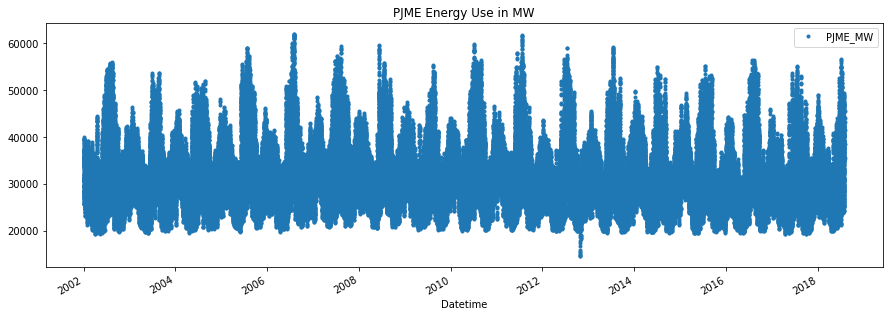

In [ ]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

### Data Treatment

Let's first take a look on outliers

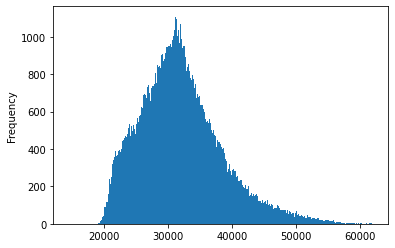

In [ ]:
df['PJME_MW'].plot(kind='hist', bins=500)

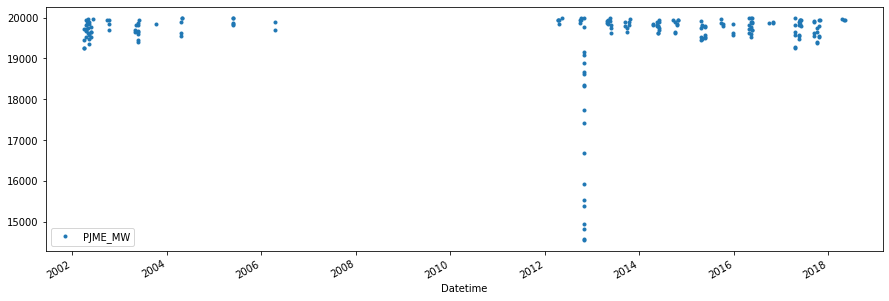

In [ ]:
df.query('PJME_MW < 20000').plot(figsize=(15,5), style='.')

We noticed that are sometimes MW less than 20000, but there are some outliers between 2012 and 2014. Let's look closer

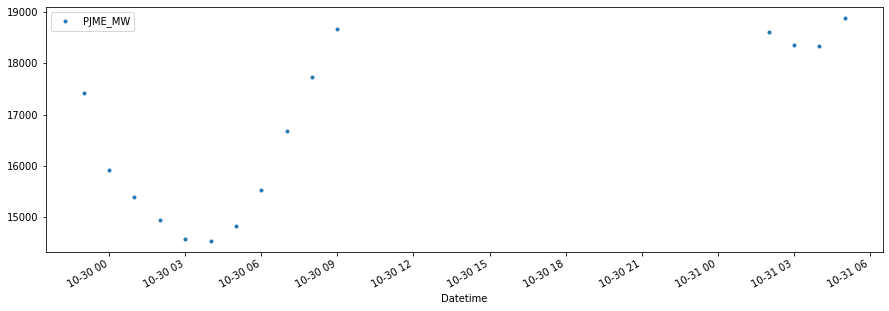

In [ ]:
df.query('PJME_MW < 19000').plot(figsize=(15,5), style='.')

Let's just copy this dataset without outliers, which are the consu,ptions below 19000

In [ ]:
df = df.query('PJME_MW > 19000').copy()

## Train / Test Split

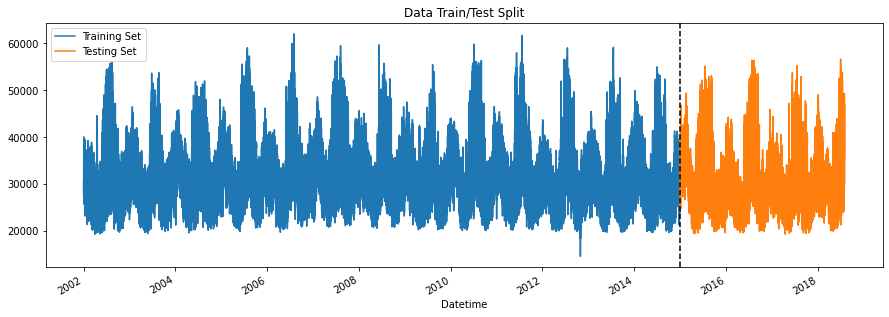

In [ ]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title = 'Data Train/Test Split')
test.plot(ax=ax, label='Testing Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set','Testing Set'])
plt.show()

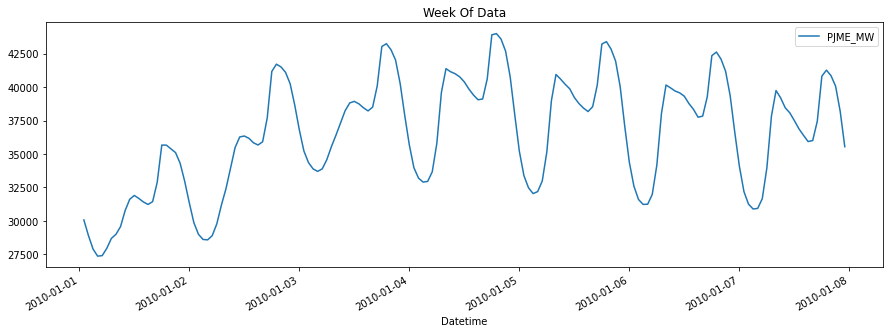

In [ ]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

We're going to improve our Train-Test Split by using Time Series Cross validation to see how each year prediction went comparing to the last one, we'll do that 5 times

### Time Series Cross Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24) #notice test size is 1 year, so 24hours, 365 days and 1 year
df=df.sort_index()

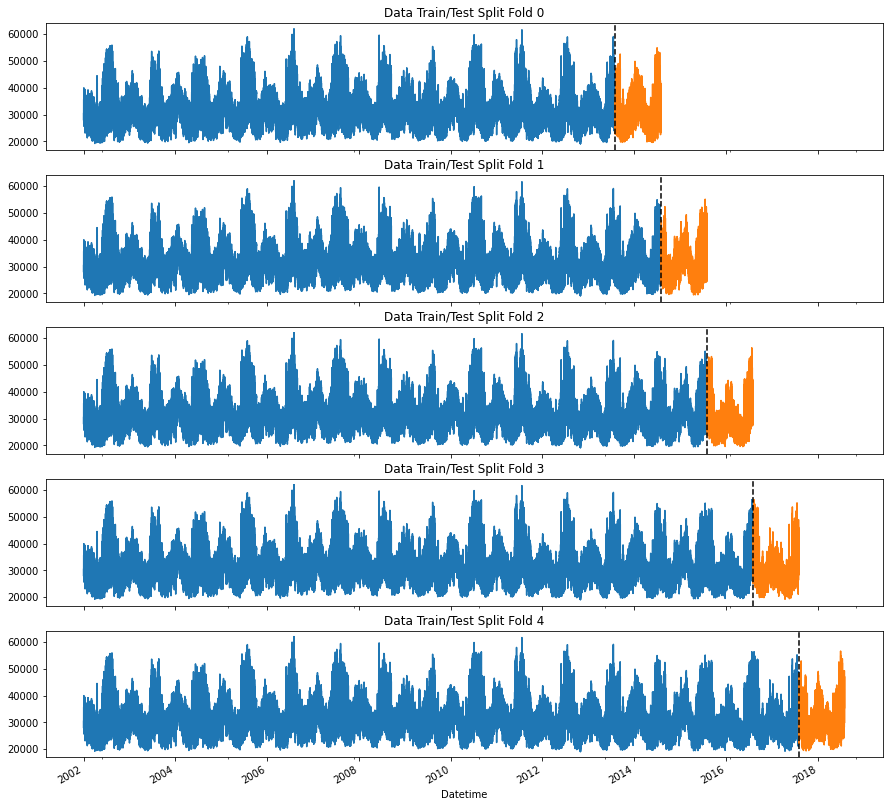

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### Creating Features

Creating Features to increase the accuracy of our analysis

In [ ]:
def create_features(df):
  df = df.copy()
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  return df

df = create_features(df)

In [ ]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215


### Visualize our Feature / Target Relationship

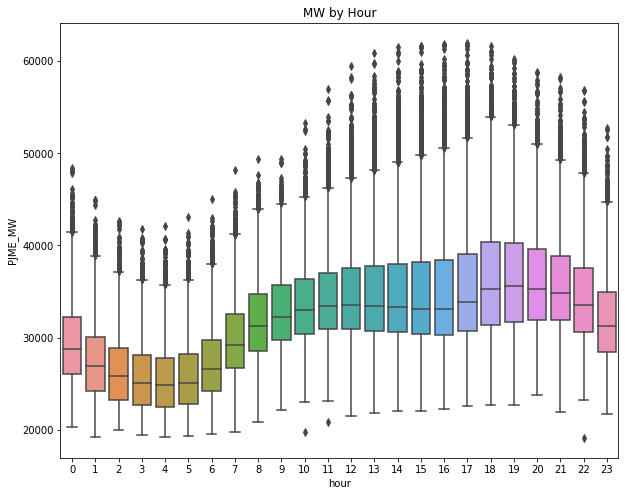

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

We can see that early in the morning the consumption decrease and tends to increase until later evening

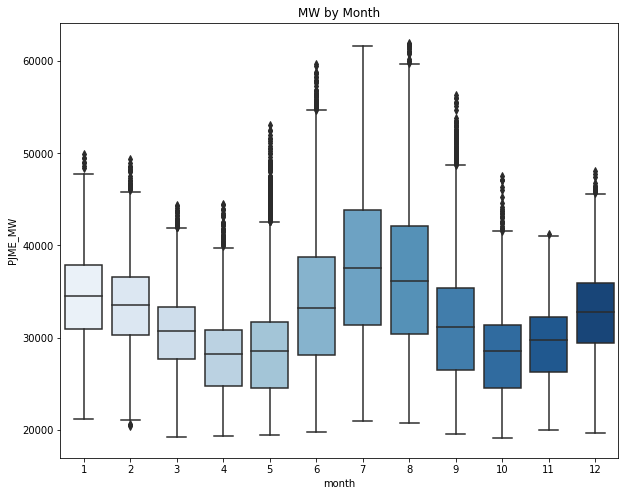

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

On month we can see there are peaks of consumption, specially in the winter, middle of the summer (probably due the use of Air Conditioner in this period)

### Creating our Regression Model using XGBoost

In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[18:53:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32464.1	validation_1-rmse:31460.2
[100]	validation_0-rmse:12547.2	validation_1-rmse:11658.1
[200]	validation_0-rmse:5860.69	validation_1-rmse:5359.45
[300]	validation_0-rmse:3975.44	validation_1-rmse:4091.12
[400]	validation_0-rmse:3510.54	validation_1-rmse:3963.72
[500]	validation_0-rmse:3355.08	validation_1-rmse:3939.29
[600]	validation_0-rmse:3278.47	validation_1-rmse:3923.03
[700]	validation_0-rmse:3227.72	validation_1-rmse:3903.98
[800]	validation_0-rmse:3189.1	validation_1-rmse:3893.5
[900]	validation_0-rmse:3159.65	validation_1-rmse:3892.36
[999]	validation_0-rmse:3134.6	validation_1-rmse:3902.8


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

### Forecast on Test using XGBoost

In [ ]:
test['prediction'] = reg.predict(X_test)

In [ ]:
df = df.merge(test['prediction'], how='left', left_index=True, right_index=True)

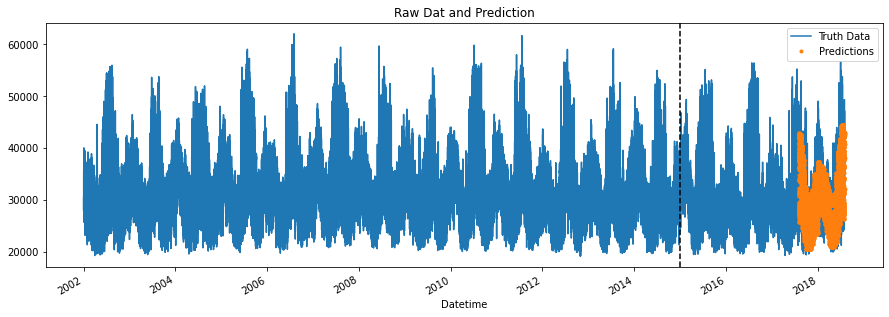

In [ ]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.axvline('01-01-2015', color='black', ls='--')
ax.set_title('Raw Dat and Prediction')
plt.show()

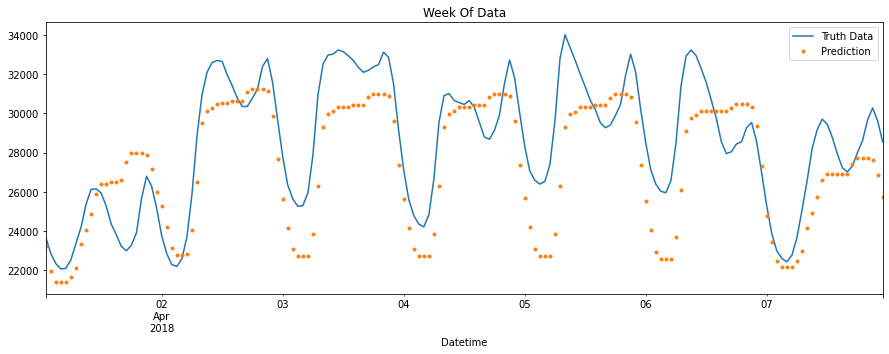

In [ ]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

### Calculate Errors

Checking the score of my forecast and which month our prediction were the worst and the best

In [ ]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score: 0.2f}')

RMSE Score on Test set:  3902.80


In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction,error
Datetime,,,,,,,,,
2017-08-03 01:00:00,29189.0,1,3,3,8,2017,215,29334.101562,145.101562
2017-08-03 02:00:00,27584.0,2,3,3,8,2017,215,28067.125000,483.125000
2017-08-03 03:00:00,26544.0,3,3,3,8,2017,215,27622.025391,1078.025391
2017-08-03 04:00:00,26012.0,4,3,3,8,2017,215,27622.025391,1610.025391
2017-08-03 05:00:00,26187.0,5,3,3,8,2017,215,27622.025391,1435.025391
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,42907.527344,1149.472656
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,42572.640625,683.359375
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,40811.738281,740.261719


In [ ]:
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2017-12-31    11437.068522
2018-01-06    11236.507975
2018-01-07    10477.414958
2018-01-05     9967.769124
2017-12-28     9833.391602
2017-12-29     9392.479085
2018-07-02     9386.350505
2017-12-30     9328.155273
2018-07-03     9242.184163
2018-01-01     9230.355632
Name: error, dtype: float64

In [ ]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2017-10-14    356.059001
2018-05-22    383.598145
2017-11-05    451.435234
2017-10-29    452.290934
2018-05-17    465.412923
2017-11-03    521.776449
2018-05-11    601.686605
2017-12-23    611.541829
2018-05-13    636.155599
2017-10-23    638.969645
Name: error, dtype: float64

As we can see, there is a lot of improvement to made because our model is not that good, we do that by adjusting some parameters before run forecast model and also create a few more features, specially on holidays that might increase on decrease energy consumption on those days.